In [1]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K




In [40]:
# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Convert to grayscale if needed (optional)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_data/benign"
malignant_dir = "/content/drive/MyDrive/Kaggle_data/malignant"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

# Combine the images
images = np.concatenate((benign_images, malignant_images), axis=0)

# Normalize images (0-1)
images = images.astype(np.float32) / 255.0  # Ensure correct dtype for normalization

# Shuffle images
np.random.shuffle(images)

print(f"Total images loaded: {images.shape[0]}")

Loaded 1800 images from /content/drive/MyDrive/Kaggle_data/benign
Loaded 1505 images from /content/drive/MyDrive/Kaggle_data/malignant
Total images loaded: 3305


In [41]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [42]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold - 25, 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold + 25, 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2644, 128, 128, 3), Training masks shape: (2644, 128, 128, 1)
Validation images shape: (661, 128, 128, 3), Validation masks shape: (661, 128, 128, 1)


In [43]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice


def rand_index(y_true, y_pred):
    """
    Calculate the Adjusted Rand Index.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.

    Returns:
    - Adjusted Rand Index value.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari

import numpy as np
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred, threshold=0.5):
    """
    Calculate Cohen's Kappa score.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Cohen's Kappa score value.
    """
    # Convert both y_true and y_pred to binary
    y_true = (np.array(y_true).flatten() > threshold).astype(int)
    y_pred = (np.array(y_pred).flatten() > threshold).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa



In [44]:
#SegNet
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras import layers, models  # Import layers and models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers  # Import the necessary layers

import tensorflow as tf
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
def segnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c5)
    u1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c4])

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c3])

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Concatenate()([u3, c2])

    u4 = layers.UpSampling2D((2, 2))(u3)
    u4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Concatenate()([u4, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model
segnet_model = segnet((128, 128, 3))


In [45]:
import numpy as np
from scipy.special import gamma

class ANBOOptimizer:
    def __init__(self, model, lb, ub, population_size=30, max_iter=100):
        self.model = model
        self.lb = lb
        self.ub = ub
        self.population_size = population_size
        self.max_iter = max_iter

        # Keep track of the layer weight shapes
        self.weight_shapes = [w.shape for w in model.get_weights()]

        # Compute total number of weights (flattened size)
        self.total_weights = sum(np.prod(shape) for shape in self.weight_shapes)

        # Initialize the population
        self.population = self.initialize_population()

        # Initialize the visit table (population_size x population_size)
        self.visit_table = np.zeros((self.population_size, self.population_size))

    def initialize_population(self):
        # Initialize a population of flattened weight vectors
        return [self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb) for _ in range(self.population_size)]

    def flatten_weights(self, weights):
        # Flatten the model weights into a 1D array
        return np.concatenate([w.flatten() for w in weights])

    def reshape_weights(self, flattened_weights):
        # Reshape the flattened weight vector back to the model's original weight shapes
        reshaped_weights = []
        start = 0
        for shape in self.weight_shapes:
            size = np.prod(shape)
            reshaped_weights.append(flattened_weights[start:start + size].reshape(shape))
            start += size
        return reshaped_weights

    def fitness(self, flattened_weights, X, y_true, batch_size=32):
        # Reshape the flattened weights to the original layer weight shapes
        reshaped_weights = self.reshape_weights(flattened_weights)
        self.model.set_weights(reshaped_weights)

        # Compute the fitness (mean squared error) using batch processing
        num_samples = X.shape[0]
        num_batches = int(np.ceil(num_samples / batch_size))

        total_loss = 0
        for batch in range(num_batches):
            start = batch * batch_size
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y_true[start:end]
            y_pred = self.model.predict(X_batch)
            total_loss += np.sum((y_pred - y_batch) ** 2)

        mean_loss = total_loss / num_samples
        return mean_loss

    def guided_foraging(self, Su, Su_tar):
        lambda_factor = np.random.normal(0, 1)
        Vu_next = Su_tar + lambda_factor * (Su - Su_tar)
        return np.clip(Vu_next, self.lb, self.ub)

    def levy_flight(self, beta=1.5):
        u = np.random.normal(0, 1)
        v = np.random.normal(0, 1)
        gamma_numerator = gamma(1 + beta) * np.sin(np.pi * beta / 2)
        gamma_denominator = gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
        levy_constant = (gamma_numerator / gamma_denominator) ** (1 / beta)
        levy_step = u / (np.abs(v) ** (1 / beta)) * levy_constant
        return levy_step

    def territorial_foraging(self, Su):
        # Exploring nearby regions
        lambda_star = np.random.normal(0, 1)
        territorial_step = lambda_star * Su
        return np.clip(Su + territorial_step, self.lb, self.ub)

    def migration_foraging(self):
        # Return a new random location
        return self.lb + np.random.rand(self.total_weights) * (self.ub - self.lb)

    def update_position(self, Su, Sj, humidity):
        levy_step = self.levy_flight()
        return Su + humidity * (Sj - Su) + levy_step

    def update_visit_table(self, worst_idx):
        # Update visit table for v-th source, v ≠ wor
        for v in range(self.population_size):
            if v != worst_idx:
                self.visit_table[worst_idx, v] += 1

    def optimize(self, X_train, y_train):
        best_solution = None
        best_fitness = float('inf')

        for iteration in range(self.max_iter):
            for i, Su in enumerate(self.population):
                fitness_val = self.fitness(Su, X_train, y_train)

                if fitness_val < best_fitness:
                    best_fitness = fitness_val
                    best_solution = Su

                # Guided Foraging
                Su_tar = self.population[np.random.randint(self.population_size)]
                Su_next = self.guided_foraging(Su, Su_tar)

                # Territorial Foraging (Local exploration)
                if np.random.rand() > 0.5:
                    Su_next = self.territorial_foraging(Su)

                # Migration Foraging (Random jump if stuck)
                if np.random.rand() > 0.7 or iteration % (2 * self.population_size) == 0:
                    worst_idx = i  # Assuming i is the worst index for now
                    Su_next = self.migration_foraging()
                    self.update_visit_table(worst_idx)  # Update visit table after migration

                # Update population with new position
                self.population[i] = Su_next

        # Return the best solution and best fitness
        return self.reshape_weights(best_solution), best_fitness


In [46]:

# Initialize the R2U-Net model
from sklearn.model_selection import train_test_split



lb = -0.0001  # Single lower bound
ub = 0.0001   # Single upper bound

# Initialize the optimizer
optimizer = ANBOOptimizer(segnet_model, lb, ub, population_size=3, max_iter=1)

# Run the optimization process
best_weights, best_fitness = optimizer.optimize(X_train, y_train)

# Set the model's weights to the best solution
segnet_model.set_weights(best_weights)





1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [47]:

segnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with early stopping
history = segnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 384ms/step - accuracy: 0.6857 - loss: 0.6160 - val_accuracy: 0.6776 - val_loss: 0.4666
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 338ms/step - accuracy: 0.7077 - loss: 0.4301 - val_accuracy: 0.7701 - val_loss: 0.3173
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 336ms/step - accuracy: 0.8038 - loss: 0.2840 - val_accuracy: 0.8238 - val_loss: 0.2322
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 335ms/step - accuracy: 0.8282 - loss: 0.2298 - val_accuracy: 0.8415 - val_loss: 0.2324
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 340ms/step - accuracy: 0.8199 - loss: 0.2534 - val_accuracy: 0.8379 - val_loss: 0.2226
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 343ms/step - accuracy: 0.8259 - loss: 0.2264 - val_accuracy: 0.8284 - val_loss: 0.2326
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - accuracy: 0.8317 - loss: 0.2184 - val_accuracy: 0.8352 - val_loss: 0.2196
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 42s 349ms/step - accuracy: 0.8284 - loss: 0.2279 - val_accu

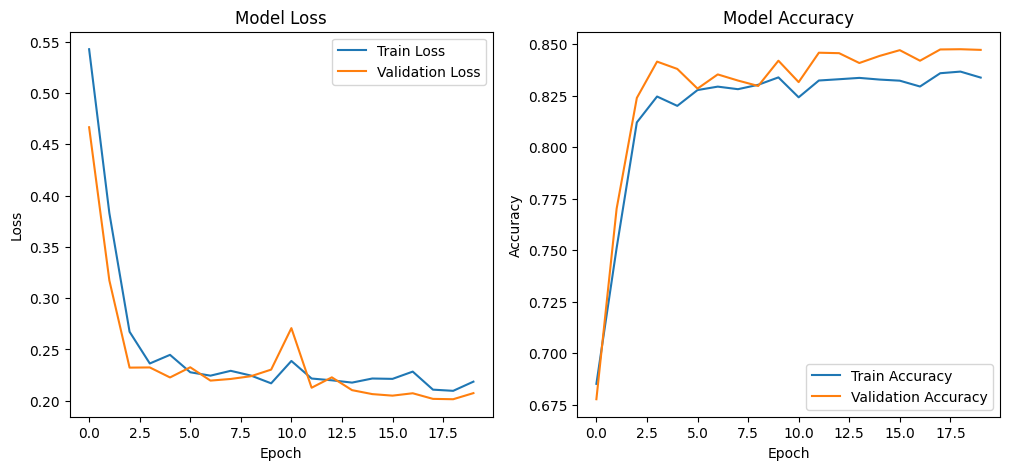

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot the last training history for the best model
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [49]:
# Predict on validation set
y_pred_val = segnet_model.predict(X_val)
# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")
cohens=cohen_kappa(y_val,y_pred_val)
print(f"Cohen's Kappa  : {cohens}")
rand=rand_index(y_val,y_pred_val)
print(f"Rand index  : {rand}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step
Jaccard Coefficient (IoU): 0.8864856546885473
Dice Coefficient : 0.9398276127733431
Cohen's Kappa  : 0.7736433232730517


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Rand index  : 0.6525348532692093


In [ ]:
predictions_benign = segnet_model.predict(benign_images)
predictions_malignant = segnet_model.predict(malignant_images)

# Convert predictions to binary and invert them
predictions_binary_benign = (predictions_benign > 0.5).astype(np.uint8)
predictions_inverted_benign = 1 - predictions_binary_benign

predictions_binary_malignant = (predictions_malignant > 0.5).astype(np.uint8)
predictions_inverted_malignant = 1 - predictions_binary_malignant

import matplotlib.pyplot as plt
# Function to display images and predicted inverted masks (no true masks)
def display_images(images, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        # Display original images
        plt.subplot(2, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])

        # Display predicted inverted masks
        plt.subplot(2, 5, i + 6)
        plt.title(f"{title} - Pred Inverted Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')

    plt.show()

# Display 5 benign images with predicted inverted masks
display_images(benign_images[:5], predictions_inverted_benign[:5], title="Benign")

# Display 5 malignant images with predicted inverted masks
display_images(malignant_images[:5], predictions_inverted_malignant[:5], title="Malignant")

In [51]:
segnet_model.save('/content/drive/MyDrive/segnet_model_ANBO.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!
